In [33]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x):
    return 3*x**2 - 4*x + 5

To plot a charge, define the x values, and then calculate the y values from those x values

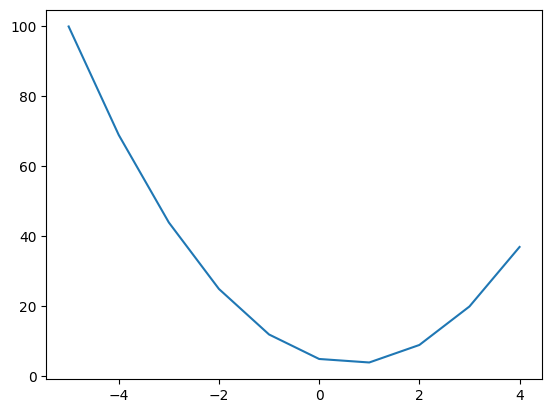

In [16]:
x = np.arange(-5, 5, 1)
y = f(x)
plt.plot(x, y)

To calculate deir

In [31]:
h = 0.000001
x = 3.0
print((f(x+h)- f(x))/h) # manual calculation
6*x - 4 # the derivative

14.000003002223593


14.0

Now, multi-variable derivatives

In [37]:
h = 0.001 # the change

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print(f'{d1=}')
print(f'{d2=}')
print(f'{(d2 - d1)/h}')

d1=4.0
d2=3.997
-3.0000000000001137


We will now do the above, but instead with a class object in Python.


self.data=4.0

In [51]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')


a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d= a*b+c
d._prev
d._op

'+'

We now know for each value exactly how it was constructed. Let's try and plot this

In [64]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
d= a*b+c
d.label = 'd'
d._prev
d._op

'+'

Now we will visualize. graphiz requires brew install graphviz

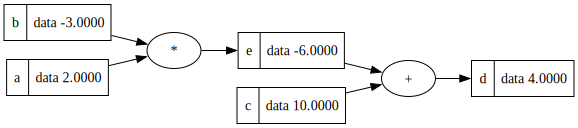

In [60]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

draw_dot(d)

We have a mathematical expression with inputs that produce a single output. Now we will create a final output.

In [65]:
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
draw_dot(L)

AttributeError: 'Value' object has no attribute 'grad'

Now we want to run backpropogation.

L is the loss function. The other variables are called the weights of the neural net. We will perform backpropogation by starting at L and determing the gradient at every node. So from the end go to the front

In [80]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0   # assume gradient is zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
d= a*b+c
d.label = 'd'

'+'

In [32]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f}" % ( n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



Now we will fill in these gradients. For L, the derivative is 1. When you change L by x, L will change by x amount. So 1 to 1.

In [71]:
L.grad = 1.0


In [73]:
def test_gradient():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    # The derivative of L with respect to a
    # Because we are increasing a by 0.001, we are seeing how that change changes L
    print((L2 - L1)/h)
test_gradient()

6.000000000000227


Alternatively, we can change L with respect to H

In [75]:
def test_gradient():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h
    # The derivative of L with respect to a
    # Because we are increasing a by 0.001, we are seeing how that change changes L
    print((L2 - L1)/h)
test_gradient()


1.000000000000334


So it is 1.

In [78]:
L = d * f


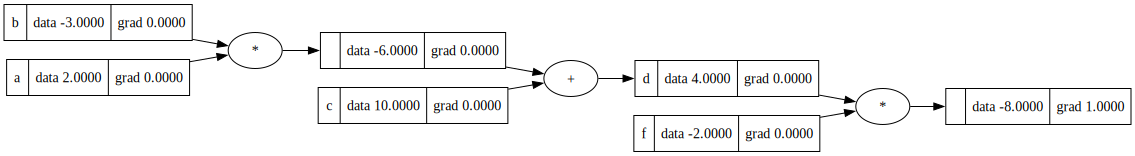

In [87]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0   # assume gradient is zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')


a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b
e.label = 'e'
d = e + c
d.label = 'd'
d= a*b+c
d.label = 'd'
f = Value(-2.0, label='f')
L = f * d
L.grad = 1
draw_dot(L)

Let's continue with backpropogation

What is the derivative of L with respect to d and f?

For d: we would like to know what is dL/dd?
L = d * f, so dL/dd = f. Proof below

(f(x+h)-f(x))/h
Plug in x = d, to get the derivative with respect to d? You plug in x = d
(f(d+h)-f(d))/h
(f*d + f*h - f*d)/h
(f*h)/h
f

Therefore, the gradient of d is just the value of f.
By symmetry, the same would hold for dL/df = d

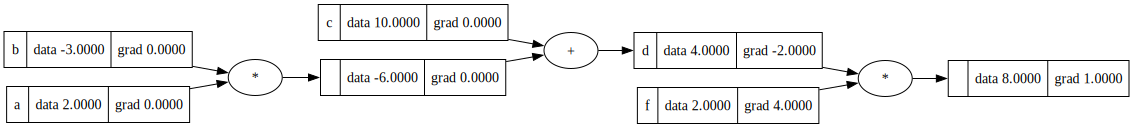

In [86]:
f.grad = 4.0
d.grad = -2.0
draw_dot(L)

Let's double check our work by running test_gradient

In [85]:
def test_gradient():
    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0 + h, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    # The derivative of L with respect to a
    # Because we are increasing a by 0.001, we are seeing how that change changes L
    print((L2 - L1)/h)
test_gradient()


3.9999999999995595


The gradient of L with respect to f is 4.0, so we are correct

Now we will derive dL/dc, the derive of L with respect to c.
We know how L is sensitive to d, but c is 2 steps away.
We know how c impacts d, and how d impacts L, so somehow c will impact L

First, we must know what is the derive of d with respect to c, dd/dc?

d = c + e

(f(x+h) - f(x))/h as h -> 0
(f(c+h) - f(c)/h)   # x = c
((c+h)+ e - (c+e))/h # f(x) = x + e, therefore f(c+h) = c + h + e
(c + h + e - c - e)/h
h/h
1.0

By symmetry, dd/de = 1.0. 

We call these two the local derivatives.


Next, we will the chain rule to calculate the derive of c with respect to L

If a variable z depends on variable y which depends on x, then z depends on x through intermediate variable y. In which case,

dz/dx = dz/dy * dy/dx

So basically, just multiply the derivatives together

dL/dc = dL/dd * dd/dc
dL/dc = -2.0 * 1

+ just distributes the derivative to all of the children notes

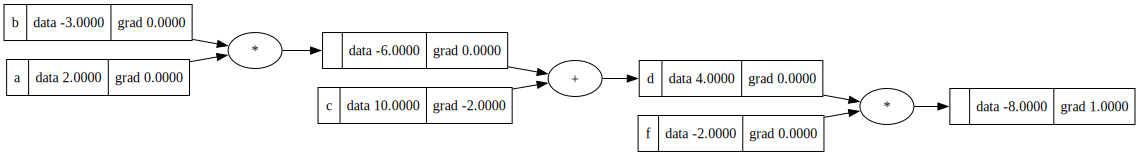

In [89]:
c.grad = -2.0
e.grad = -2.0
draw_dot(L)

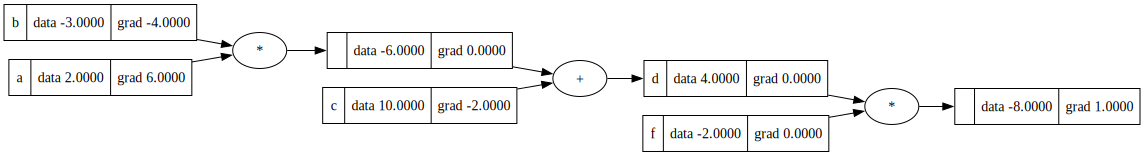

In [92]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2
draw_dot(L)

dL / de = -2.0

e = a  * b
de / da ? b
dL / da = (dL / de) * (de / da)

In [ ]:
a.data += a.grad

In [93]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a+b
d = e+c
L = d + f
print(L.data)

7.0


Now, let's backpropogate through a neuron

What is a neuron?

There is an input, and there is a synapse which goes into the cell body

A cell body for a neuron has something called a squashing function, we can plot it similar to a tanh function

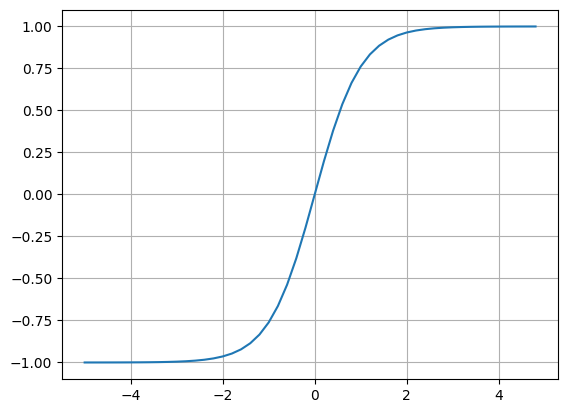

In [94]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

The inputs as they came in get squashed, at 0 they go positive, but as you get more positive, it will plateau.

We will cap it smoothly at one, at negative side cap it smoothly

Let's do an example. This is a neuron, with two inputs

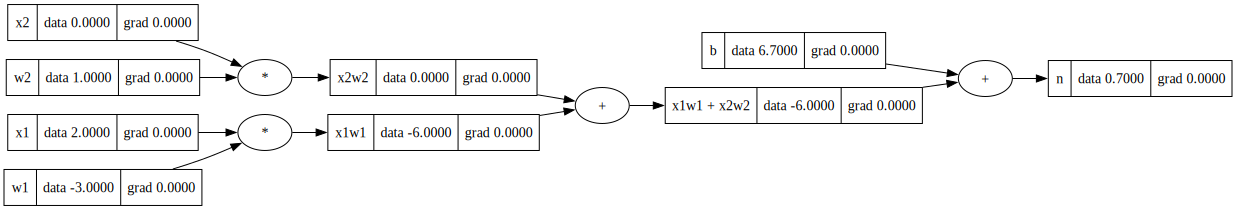

In [96]:
# inputs to the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights of the neuron, the synaptics strength of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
# the cell body, raw activation without activation function
n = x1w1x2w2 + b; n.label = 'n'

draw_dot(n)


For the activation function, we need something like tanh which we haven't implemented yet in our Value function, so let's do that

We will cluster up the expression, and implement tanh

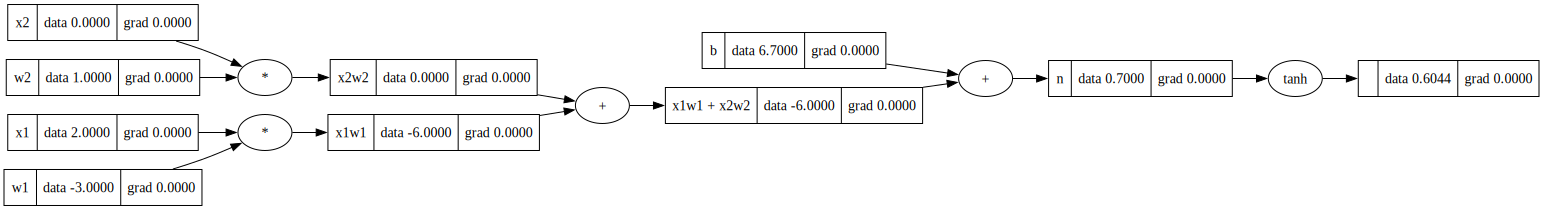

In [98]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0   # assume gradient is zero
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'{self.data=}'
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')

    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n) - 1)/(math.exp(2*n)+1)
        out = Value(tanh, (self, ), 'tanh')
        return out

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
draw_dot(o)


As you increase the bias, the tanh will more severely cap the data to 1.0

For the sake of having nice numbers, we will modify the bias to be a bit more desirable for the gradients we end up with

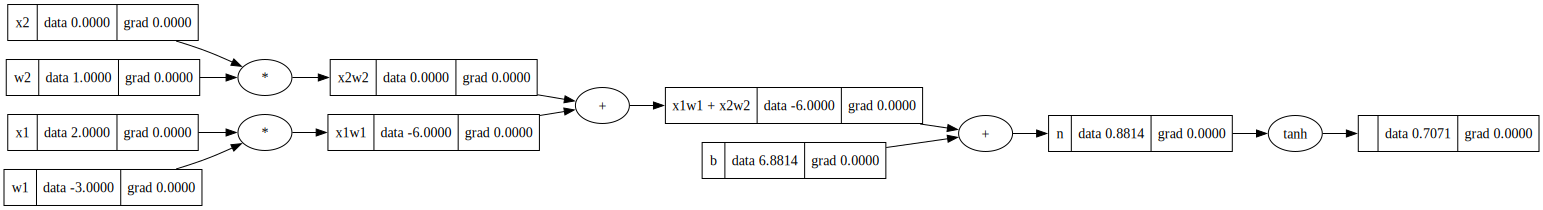

In [101]:
# inputs to the neuron
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
# the cell body, raw activation without activation function
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
draw_dot(o)

Now, we will do backpropogation and fill in all the gradients.

What we really care about is the derivative of these neurons on the weights, w2 and w1, which is what we will change as part of the neural net.

In the real world,  at the end we will have a loss function which all these neurons will feed into. And the entire premise of a neural net is to increase the loss function which measures the accurracy of the neural net.

In [102]:
o.grad = 1.0

To backpropogate through tanh, we need to know local derivative of tanh. W

What is d*tanhx/dx? Just use wikipedia/google for this.

do/dx = 1 - o**2

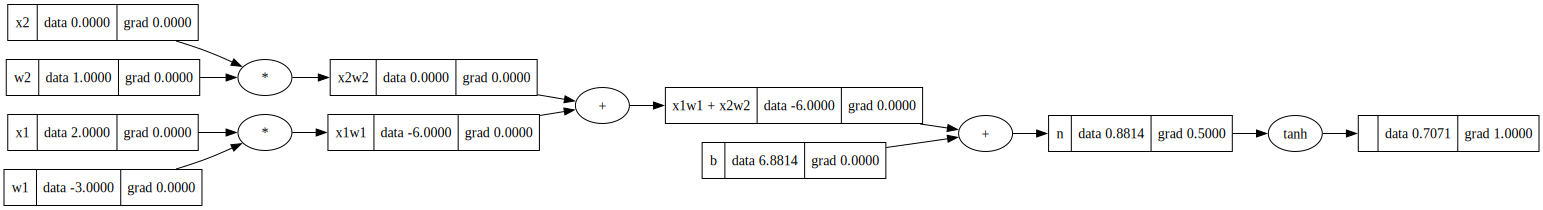

In [105]:
n.grad = 1 - o.data**2
n.grad
draw_dot(o)

Remember, the + operation just moves the gradient over

In [107]:
x1w1x2w2.grad = 0.5
b.grad = 0.5
x2w2.grad = 0.5
x1w1.grad = 0.5

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

Let's build out the backpropogation algorithm

In [11]:
import math
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0  # assume gradient is zero
        self._backward = lambda: None   # will apply the chain rule, how we will chain output gradients into input gradients
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.data=}"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        # set the function to propogate the gradient
        # take out.grad and populate it to self.grad and other.grad
        def _backward():
            # the local derivative is other.data
            # basically, what we did above x2.grad = w2.data * x2w2.grad
            # w2.grad = x2.data * x2w2.grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        # apply chain rule for mulitplicatio
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self,), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad
        out._backward = _backward

        return out

# inputs to the neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights of the neuron, the synaptics strength of each input
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
x1w1 = x1 * w1
x1w1.label = "x1w1"
x2w2 = x2 * w2
x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1w1 + x2w2"
# the cell body, raw activation without activation function
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()

Now instead of doing it manually, just call the backwards function

In [12]:
o.grad = 1.0
o._backward()
n.grad

0.4999999999999999

Yep, that's the result we got before. So we're on the right track

In [16]:
n._backward()
b.grad
x1w1x2w2.grad

0.4999999999999999

Topological sort is laying out a graph so all of the edges go from left to right. We need it for neural nets because we want to make sure we calclate all of the children's backpropogations 

In [17]:
topo = []
visited = set()
def topological_sort(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            topological_sort(child)
        topo.append(v)
topological_sort(o)
topo

[self.data=6.881373587019543,
 self.data=-3.0,
 self.data=2.0,
 self.data=-6.0,
 self.data=0.0,
 self.data=1.0,
 self.data=0.0,
 self.data=-6.0,
 self.data=0.8813735870195432,
 self.data=0.7071067811865476]

In [19]:
for node in reversed(topo):
    node._backward()


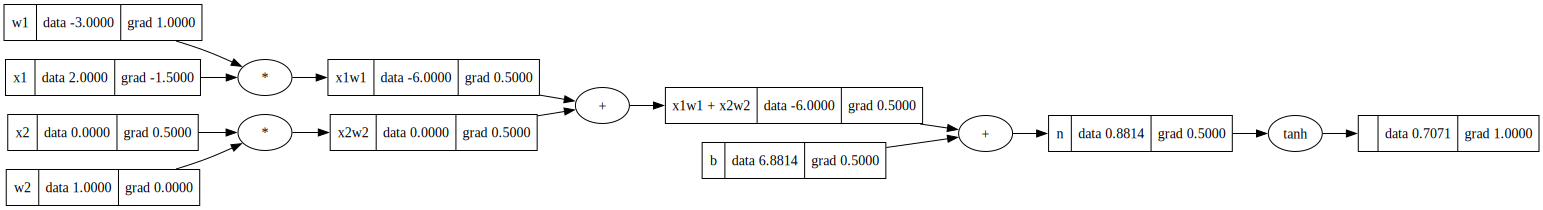

In [24]:
draw_dot(o)


Therefore, the final version of Value will be as follows

In [4]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0  # assume gradient is zero
        self._backward = (
            lambda: None
        )  # will apply the chain rule, how we will chain output gradients into input gradients
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.data=}"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        # set the function to propogate the gradient
        # take out.grad and populate it to self.grad and other.grad
        def _backward():
            # the local derivative is other.data
            # basically, what we did above x2.grad = w2.data * x2w2.grad
            # w2.grad = x2.data * x2w2.grad
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        # apply chain rule for mulitplicatio
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self,), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

But there's a bug

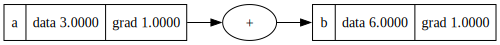

In [8]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

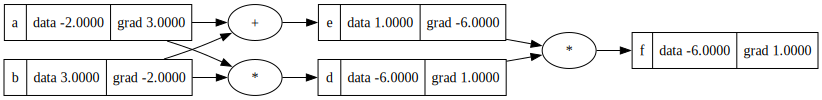

In [9]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a* b; d.label = 'd'
e = a + b; e.label ='e'
f = d*e; f.label ='f'
f.backward()
draw_dot(f)


If self and other are the same object, we override the gradient. 
If a variable is used more than once, we have to acculumate the gradients instead of adding them

In [10]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0  # assume gradient is zero
        self._backward = (
            lambda: None
        )  # will apply the chain rule, how we will chain output gradients into input gradients
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.data=}"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        # set the function to propogate the gradient
        # take out.grad and populate it to self.grad and other.grad
        def _backward():
            # the local derivative is other.data
            # basically, what we did above x2.grad = w2.data * x2w2.grad
            # w2.grad = x2.data * x2w2.grad
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        # apply chain rule for mulitplicatio
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self,), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

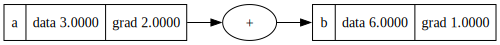

In [12]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

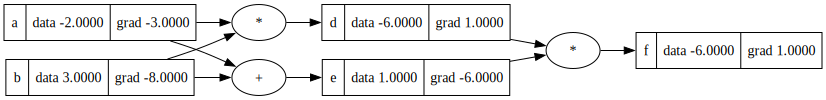

In [11]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a* b; d.label = 'd'
e = a + b; e.label ='e'
f = d*e; f.label ='f'
f.backward()
draw_dot(f)

Convenience, let's automatically convert to Value for each operation

In [14]:
Value(1.0) + 1

AttributeError: 'int' object has no attribute 'data'

In [24]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0  # assume gradient is zero
        self._backward = (
            lambda: None
        )  # will apply the chain rule, how we will chain output gradients into input gradients
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.data=}"

    def __add__(self, other):
        value = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + value.data, (self, other), "+")

        # set the function to propogate the gradient
        # take out.grad and populate it to self.grad and other.grad
        def _backward():
            # the local derivative is other.data
            # basically, what we did above x2.grad = w2.data * x2w2.grad
            # w2.grad = x2.data * x2w2.grad
            self.grad += 1.0 * out.grad
            value.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        # apply chain rule for mulitplicatio
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self,), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [26]:
a = Value(2.0)
a * 2
2*a

self.data=4.0

Let's add exponentiation and vision

In [170]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0  # assume gradient is zero
        self._backward = (
            lambda: None
        )  # will apply the chain rule, how we will chain output gradients into input gradients
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.data=}"

    def __add__(self, other):
        value = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + value.data, (self, other), "+")

        # set the function to propogate the gradient
        # take out.grad and populate it to self.grad and other.grad
        def _backward():
            # the local derivative is other.data
            # basically, what we did above x2.grad = w2.data * x2w2.grad
            # w2.grad = x2.data * x2w2.grad
            self.grad += 1.0 * out.grad
            value.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        # apply chain rule for mulitplicatio
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self,), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad

        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backwarad():
            self.grad += out.data * out.grad
        self._backward = _backwarad

        return out

    def backward(self):
        topo = []
        visited = set()
        def topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    topological_sort(child)
                topo.append(v)
        topological_sort(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()

In [44]:
a = Value(2.0)
a.exp()

self.data=7.38905609893065

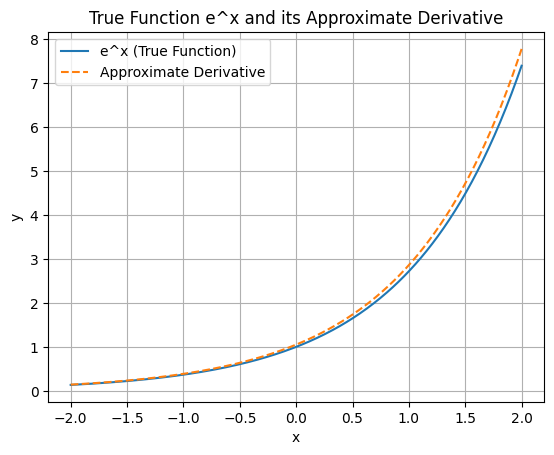

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function e^x
def f(x):
    return np.exp(x)

# Approximate the derivative using the difference quotient
def derivative_approx(x, h):
    return (f(x + h) - f(x)) / h

# Generate x values
x = np.linspace(-2, 2, 400)

# Calculate the true value of e^x
y_true = f(x)

# Approximate the derivative with a small h value
h = 0.1
y_derivative_approx = derivative_approx(x, h)

# Create the plot
plt.plot(x, y_true, label="e^x (True Function)")
plt.plot(x, y_derivative_approx, linestyle='--', label="Approximate Derivative")

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('True Function e^x and its Approximate Derivative')

# Add a grid for better visualization
plt.grid(True)

# Show legend
plt.legend()

# Display the plot
plt.show()


The derivative of 2^t is just 2^t  multiplied by some constant

$$
\frac{2^(t+dt)-2^t}{dt} 
$$
$$
\frac{2t*2dt-2^t}{dt}
$$
$$
2^t*\frac{2dt-1}{dt}
$$

As dt->0, approach some constnat

$$
2^t*\frac{2*0.000001-1}{0.000001} = 0.693...
$$

All exponential functions are proportional to their own derivative, the the definition of the exponential function e is that its derivatve is 1
Use the chain rule to prove this out

$$
\frac{d(e^{et})}{dt} = 3*e^{3t}
$$
$$


When you see somethign written as e^x, it gives that content in exponent a meaning. So it's just easier to write down that instead of 2^x

Now let's define division

In [151]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0  # assume gradient is zero
        self._backward = (
            lambda: None
        )  # will apply the chain rule, how we will chain output gradients into input gradients
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"{self.data=}"

    def __add__(self, other):
        value = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + value.data, (self, other), "+")

        # set the function to propogate the gradient
        # take out.grad and populate it to self.grad and other.grad
        def _backward():
            # the local derivative is other.data
            # basically, what we did above x2.grad = w2.data * x2w2.grad
            # w2.grad = x2.data * x2w2.grad
            self.grad += out.grad
            value.grad += out.grad

        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        # apply chain rule for mulitplicatio
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self,), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad

        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backwarad():
            self.grad += out.data * out.grad
        self._backward = _backwarad

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):
        return self * other**-1

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

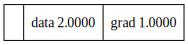

In [60]:
a = Value(2.0)
a**2
a.backward()
draw_dot(a)

We will now try and reimplement tanh using the exponential definition

In [65]:
# inputs to the neuron
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights of the neuron, the synaptics strength of each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
# the cell body, raw activation without activation function
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'
o.backward()
draw_dot(n)


AttributeError: 'int' object has no attribute '_prev'

# Lets do it in pytorch

In [78]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88137]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print(x2.grad.item())
print(w2.grad.item())
print(x1.grad.item())
print(w1.grad.item)


0.7071050214706146
0.5000024886110417
0.0
-1.500007465833125
1.0000049772220834


So we get the same thing as micrograd. But pytorch is just a lot more efficient and can scale out a lot better.

Now we, can start building neural nets, which are a class of mathematical expressions.

Goal: 2 layer perceptron

# Create Neuron using api pytorch


In [8]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

x = [2.0, 3.0]
n = Neuron(2)
n(x)
layer = Layer(2,3)
print(layer(x))

AttributeError: 'Value' object has no attribute 'tanh'

In [5]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

x = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(x)
draw_dot(n(x))


NameError: name 'Layer' is not defined

Let's create 4 examples. 4 inptus into the neural net

In [166]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

4 desires targets when fed the corresponding examples

In [165]:

ys = [1.0, -1.0, -1.0, 1.0] #desired targets 

In [164]:
ypred = [n(x) for x in xs]
print(ypred)

[self.data=-0.511877667881639, self.data=-0.8239303050040273, self.data=-0.4556828086471651, self.data=-0.5395778550801819]


So we're off on the desired target for all of these by quite a bit. So let's tune the weights to predict the target

The trick is to calculate a single number which calculates total measure of neural net performance. We want to minimize loss

# Implement mean squared error loss
For each yground truth and output, we will subtract them

In [163]:
loss = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
print(loss)

[self.data=2.2857740826392234, self.data=0.03100053749597485, self.data=0.29628120480223863, self.data=2.370299971853293]


Because 0.5 is so different from -1. the first one will be larger
You only get 0 when yout == ygt.

In [171]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
print(loss)

TypeError: unsupported operand type(s) for ** or pow(): 'Value' and 'int'

We want to minimize loss, the lower it can be is 0.

In [169]:
loss.backward()

self.data=2.6975817141515064
self.data=2.370299971853293
self.data=-1.5395778550801817
1.0


AttributeError: 'float' object has no attribute '_prev'

In [33]:
import math
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label='test'):
        self.data = data
        self.grad = 0
        self.label = label
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def tanh(self):
        n = self.data
        tanh = (math.exp(2 * n) - 1) / (math.exp(2 * n) + 1)
        out = Value(tanh, (self,), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad
        out._backward = _backward

        return out

In [114]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred =[n(x) for x in xs]
ypred 

[Value(data=0.9999999912422438, grad=0),
 Value(data=0.9999999999989715, grad=0),
 Value(data=0.999999991242238, grad=0),
 Value(data=0.9999999912422438, grad=0)]

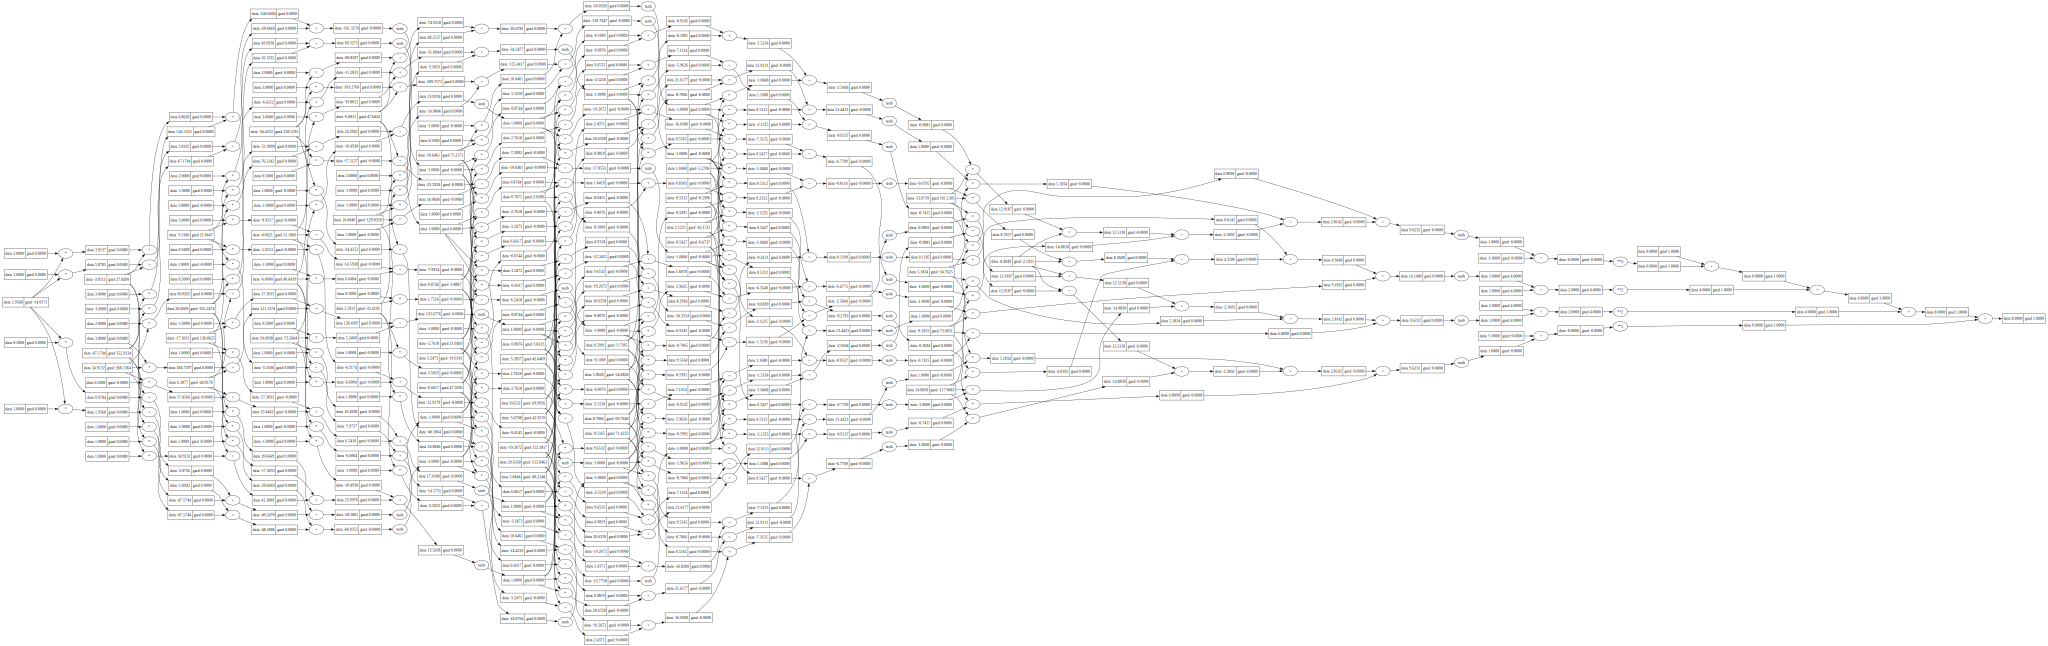

In [115]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss.backward()
draw_dot(loss)

In [37]:
n

Next task: Gather up all parameters of the neuron net. And then adjust them by some amount depending on the gradient

In [116]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
n.parameters()
len(n.parameters())


41

In [117]:
x = [2.0, 3.0, -1.0]

n = MLP(3, [4, 4, 1])
n(x)
n.parameters()
len(n.parameters())
loss.backward()

In [118]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss.backward()

In [120]:
n.parameters()

[Value(data=-0.9770515158996005, grad=-0.006719151041882851),
 Value(data=-0.32133025424043926, grad=-0.017975925898538626),
 Value(data=-0.679922316741435, grad=-0.07953756006115682),
 Value(data=-0.11468102754971232, grad=-0.050333554203070736),
 Value(data=0.3878056496348312, grad=-1.4119285517958984),
 Value(data=0.590347574954337, grad=0.8938657581739178),
 Value(data=0.30114184666363086, grad=-1.9108438345838525),
 Value(data=-0.005719338585638223, grad=-0.5534260268131473),
 Value(data=0.5674995724464049, grad=-0.29218496450727627),
 Value(data=-0.23987253102067063, grad=-0.49082291520992816),
 Value(data=0.6714809072789878, grad=1.0121204134332462),
 Value(data=-0.42229782194079357, grad=0.18689874564291256),
 Value(data=0.11674817670171, grad=0.25426510081985637),
 Value(data=0.9949410190514967, grad=-0.09281715440486803),
 Value(data=0.4206969033248271, grad=0.033503170677378465),
 Value(data=0.5499815374591006, grad=0.0768756665490908),
 Value(data=-0.325653261648299, grad=0

Now, update the parameters according to the gradient

In [146]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [147]:
n.layers[0].neurons[0].w[0].grad

-0.9531252760530521

In [148]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss.backward()
loss

Value(data=0.5619333356478423, grad=1)

In [149]:
ypred

[Value(data=0.6088733202517884, grad=-0.7822533594964232),
 Value(data=-0.8321116597968273, grad=0.33577668040634534),
 Value(data=-0.3911410160905884, grad=1.2177179678188232),
 Value(data=0.8997129172146039, grad=-0.20057416557079222)]

Looking good, the above took about 10 passes

In [150]:
n.parameters()

[Value(data=-0.9494090018987353, grad=-0.9816015667078579),
 Value(data=-0.2924110322902002, grad=-1.0079563280972654),
 Value(data=-0.6907597731833369, grad=0.7458428186102558),
 Value(data=-0.08112993910358901, grad=-0.9822429768492206),
 Value(data=0.6504042435256997, grad=-3.7009911411040926),
 Value(data=0.3298066235421656, grad=6.223403466627133),
 Value(data=0.7611315706758525, grad=-10.062063771812753),
 Value(data=0.07248830709412653, grad=-0.7542140386254461),
 Value(data=0.4895313442578693, grad=4.232020097942961),
 Value(data=-0.3329269810705811, grad=5.375747142652085),
 Value(data=0.6549464101489058, grad=-4.7100852508168325),
 Value(data=-0.4921039723757213, grad=1.058039519457112),
 Value(data=0.19442491932512534, grad=-2.5965024600211306),
 Value(data=0.9724008662515692, grad=0.7633437908265995),
 Value(data=0.4354995158756243, grad=-0.449359737117931),
 Value(data=0.5787015938515584, grad=-0.9414447504317719),
 Value(data=-0.4437878429356948, grad=1.9783950408570556),

# Implementing the training loop

In [151]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    loss.backward()

    # update the data using the gradient
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 0.5619333356478423
1 0.4143888923234701
2 0.2667419081802289
3 0.10276690340293747
4 0.027750905593875736
5 0.007178096866419578
6 0.0020888837847061023
7 0.0007156186700811009
8 0.0002930604684357602
9 0.0001457604247288376
10 8.864892915435859e-05
11 6.449861967353188e-05
12 5.349706828069405e-05
13 4.8061914929098615e-05
14 4.505494397776749e-05
15 4.310920133870222e-05
16 4.16106571272219e-05
17 4.027678391475882e-05
18 3.897448526986719e-05
19 3.764059332352341e-05


In [153]:
ypred

[Value(data=0.9960753095960072, grad=-0.007849380807985584),
 Value(data=-0.9996488729332469, grad=0.0007022541335062193),
 Value(data=-0.9996771918724491, grad=0.0006456162551018441),
 Value(data=0.9953085286687319, grad=-0.009382942662536253)]

In [ ]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update the data using the gradient
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

In [155]:
ypred

[Value(data=0.9960753095960072, grad=-0.007849380807985584),
 Value(data=-0.9996488729332469, grad=0.0007022541335062193),
 Value(data=-0.9996771918724491, grad=0.0006456162551018441),
 Value(data=0.9953085286687319, grad=-0.009382942662536253)]